In [19]:
import scipy.io as io

# load the data from the SuiteSparse Matrix Collection format
#   https://www.cise.ufl.edu/research/sparse/matrices/
graph_name = 'qh882'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
graph

<882x882 sparse matrix of type '<class 'numpy.float64'>'
	with 3354 stored elements in Compressed Sparse Column format>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.sparse.csgraph as csgraph

# find the shortest paths using dijkstra's
# note: if any path length is infinite i.e. we have disconnected subgraphs,
#       then this cell will work but the rest of the script won't.
d = csgraph.shortest_path(graph, directed=False, unweighted=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Graph has negative weights: dijkstra will give inaccurate results if the graph contains negative cycles. Consider johnson or bellman_ford.
  # Remove the CWD from sys.path while we load stuff.


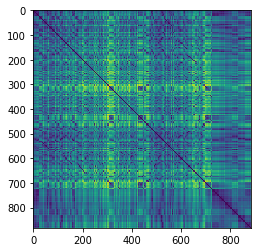

In [21]:
# show the shortest paths in a heat map.
# If any squares are white, then infinite paths exist and the algorithm will fail.
plt.imshow(d)
n = d.shape[0]

In [22]:
# initialise an array of indices to randomise relaxation order
constraints = []

# only use index pairs for i<j
w_min = float('inf')
w_max = 0
for i in range(n):
    for j in range(i):
        # w is w_ij from the MDS stress equation
        w = 1/d[i,j]**2
        w_min = min(w, w_min)
        w_max = max(w, w_max)
        constraints.append((i,j,w))

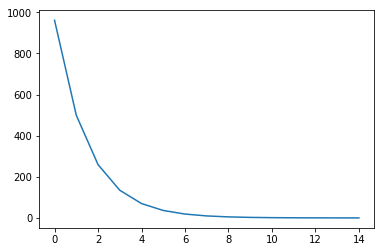

In [23]:
# determine the annealing schedule
num_iter = 15
epsilon = 0.1

eta_max = 1/w_min
eta_min = epsilon/w_max

lambd = np.log(eta_min / eta_max) / (num_iter - 1);
eta = lambda t: eta_max*np.exp(lambd*t)

# set up the schedule as an exponential decay
schedule = []
for i in range(num_iter):
    schedule.append(eta(i))
    
plt.plot(schedule)

In [24]:
import random

# initialise an array of 2D positions
positions = np.random.rand(n, 2)

import datetime
start = datetime.datetime.now()

for c in schedule:
    # shuffle the relaxation order
    random.shuffle(constraints)
    constraints
        
    for i,j,w in constraints:
        wc = w*c
        if (wc > 1):
            wc = 1
        
        pq = positions[i] - positions[j]
        # mag is |p-q|
        mag = np.linalg.norm(pq)
        # r is the minimum distance each vertex has to move to satisfy the constraint
        r = (d[i,j] - mag) / 2
        m = wc * r * pq/mag
        
        positions[i] += m
        positions[j] -= m

    print('.', end='')

end = datetime.datetime.now()
print(end - start)

...............0:01:18.582858


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


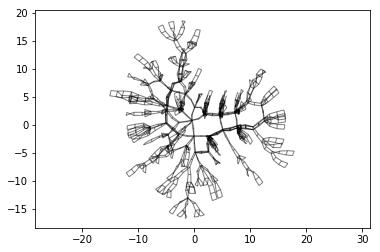

In [25]:
from matplotlib import collections as mc

plt.axis('equal')
ax = plt.axes()
ax.set_xlim(positions[:,0].min()*1.1, positions[:,0].max()*1.1)
ax.set_ylim(positions[:,1].min()*1.1, positions[:,1].max()*1.1)

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.5)
ax.add_collection(lc)

plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [26]:
stress = 0
for i in range(n):
    for j in range(i):
        pq = positions[i] - positions[j]
        mag = np.linalg.norm(pq)
        
        stress += (1/d[i,j]**2) * (d[i,j]-mag)**2
        
print('stress = {:.0f}'.format(stress))

stress = 18733
